<a href="https://colab.research.google.com/github/ginawelsh/codabunga/blob/main/Copy_of_ML_ass3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install and import dependencies for notebook

!pip install datasets
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import gc
import random
import numpy as np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
# memory/GPU management processes

# call python's garbage collector
gc.collect()

# empty cache for torch gpu
torch.cuda.empty_cache()

# set processor to torch GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print out which device is being used
print("Using device:", device)


Using device: cuda


In [ ]:
# load imdb dataset from huggingface datasets
dataset = load_dataset("imdb")

# split data into train and test subsets
train_data, test_data = dataset["train"], dataset["test"]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# TOKENIZE TEXTUAL DATA

# import BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


def tokenize(examples):
  # use BERT tokenizer method to get tokens of length 512 out of imdb textual data
  tokens = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)
  return tokens


# tokenize train and test sets
tokenized_train = train_data.map(tokenize, batched=True)
tokenized_test = test_data.map(tokenize, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
# LOAD DATA USING PYTORCH DATALOADER

# reformat train and test data into torch tensor format
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# apply dataloader to test and train sets, make sure training dataset is shuffled with each epoch
train_loader = DataLoader(tokenized_train, batch_size=16, shuffle=True)
test_loader = DataLoader(tokenized_test, batch_size=16)


In [ ]:
# create additional layer for classification task
class BERTClassifier(nn.Module):
    def __init__(self):
        # call constructor of parent class
        super(BERTClassifier, self).__init__()
        # load BERT pre-trained model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # set regularisation term (neural network dropout reg.)
        self.dropout = nn.Dropout(0.3)
        # map output to 2 classes
        self.linear = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        # run inputs through BERT model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # pass through tanh activated linear layer
        pooled_output = outputs.pooler_output
        # run drop out layer for regularisation
        dropped = self.dropout(pooled_output)
        # return logits
        return self.linear(dropped)

#  use processing device (GPU or CPU)
model = BERTClassifier().to(device)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# ensure regularisation directly impacts parameters
optimiser = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# use cross entropy loss function
loss_fn = nn.CrossEntropyLoss()


In [ ]:
epochs = 3
train_losses, test_accuracies = [], []


for epoch in range(epochs):
    # train model on processing device
    model.train()
    # initialise epoch loss
    epoch_loss = 0

    # go through batch on data loader
    for batch in train_loader:
        # reset gradients of optimised torch tensors
        optimiser.zero_grad()

        # move to GPU/CPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask)

        # calculate loss
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimiser.step()
        epoch_loss += loss.item()


    train_losses.append(epoch_loss / len(train_loader))

    # swtich to evaluation mode
    model.eval()
    all_preds, all_labels = [], []

    # evaluate using test data
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # measure accuracy on test data
    accuracy = accuracy_score(all_labels, all_preds)
    test_accuracies.append(accuracy)
    print(f"Epoch {epoch + 1}: Loss = {train_losses[-1]:.4f}, Test Accuracy = {accuracy:.4f}")

    # clear cuda cache
    torch.cuda.empty_cache()


Epoch 1: Loss = 0.2414, Test Accuracy = 0.9392
Epoch 2: Loss = 0.1242, Test Accuracy = 0.9367
Epoch 3: Loss = 0.0609, Test Accuracy = 0.9344


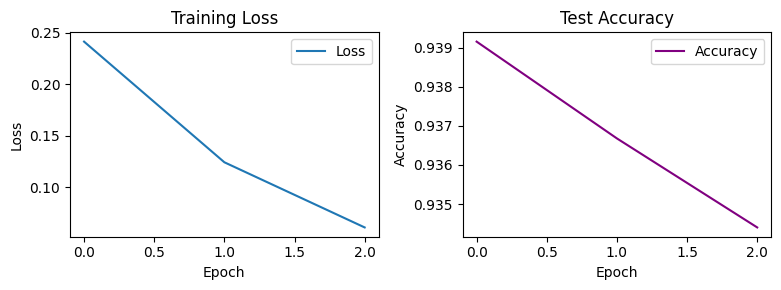

In [ ]:
# plot diagrams

# plot loss over training epochs
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# plot test accuracy over epochs
plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Accuracy', color='purple')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# create random baseline - random 0s and 1s

random_preds = [random.randint(0,1) for _ in range(len(test_data))]

baseline_accuracy = accuracy_score(test_data["label"], random_preds)

print(f"Random baseline accuracy: {baseline_accuracy:.4f}")


Random baseline accuracy: 0.4997


Comments on what you thought was hard in the assignment, what you think was educational, what took most time, and which parts might be unnecessarily tricky.


There were a few parts to the assignment that were tricky. This was the first time where I had to incorporate GPU memory management explicitly within the code in order to have sufficient computational power for model training. But at the same time, this was educational in illustrating how higher computational power can make a drastic difference to training time.

I also had to learn how to incorporate the pre-trained elements of the BERT classifier with my own additional layer to fine-tune it for the classification task. Here, I learnt about how to pass the output of the BERT model through the linear layer (to map the output to 2 classes), while also regularlising the output using dropout.

Waiting for the output of the training process took the longest time, even with high computational GPU power. Each epoch took around 25 minutes to train, requiring uninterrupted connection to the internet. Initially, the processing time was longer (~45 min per epoch), until I increased my batch size from 8 to 16, which sped up the training process.

Overall, the assignment increased my understanding of the realities of incorporating pre-trained, multi-task models to a specific task.
